In [1]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from hypersync_integrate import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_draw import *

sb.set_theme(style="ticks", context="notebook")

## Versions of rhs

In [2]:
def rhs_yuanzhao(t, theta, N, K1, K2, sigma0, sigma, return_tris=False):
    """
    RHS
    
    Parameters
    ----------
    sigma : float
        Triplet coupling strength
    K1, K2 : int
        Pairwise and triplet nearest neighbour ranges
    """
    dtheta_dt = np.zeros(N)

    # pairwise coupling
    for ii in range(N):
        for jj in range(-K1,K1+1):
            dtheta_dt[ii] +=  sigma0*np.sin(theta[(ii+jj)%N] - theta[ii])/K1
    tris = []
    # triadic coupling
    idx = list(range(-K2,0)) + list(range(1,K2+1))
    for ii in range(N):
        for jj in idx:
            for kk in idx:
                if jj != kk:
                    tris.append([ii, (ii+jj)%N, (ii+kk)%N])
                    #print([ii, (ii+jj)%N, (ii+kk)%N])
                    dtheta_dt[ii] +=  sigma*sin(theta[(ii+kk)%N] + theta[(ii+jj)%N] - 2*theta[ii])/(K2*(2.0*K2-1))
    
    #print(len(tris))
    if return_tris:
        return dtheta_dt, tris
    else:
        return dtheta_dt

In [3]:
def rhs_yuanzhao(t, theta, N, K1, K2, sigma0, sigma):
    """
    RHS
    
    Parameters
    ----------
    sigma : float
        Triplet coupling strength
    K1, K2 : int
        Pairwise and triplet nearest neighbour ranges
    """
    dtheta_dt = np.zeros(N)

    # pairwise coupling
    for ii in range(N):
        for jj in range(-K1,K1+1):
            dtheta_dt[ii] +=  sigma0*np.sin(theta[(ii+jj)%N] - theta[ii])/K1
    # triadic coupling
    idx = list(range(-K2,0)) + list(range(1,K2+1))
    for ii in range(N):
        for jj in idx:
            for kk in idx:
                if jj != kk:
                    #print([ii, (ii+jj)%N, (ii+kk)%N])
                    dtheta_dt[ii] +=  sigma*sin(theta[(ii+kk)%N] + theta[(ii+jj)%N] - 2*theta[ii])/(K2*(2.0*K2-1))
    
    return dtheta_dt

In [4]:
from math import sin


def rhs_oneloop(t, theta, N, K1, K2, sigma0, sigma):
    """
    RHS

    Parameters
    ----------
    sigma : float
        Triplet coupling strength
    K1, K2 : int
        Pairwise and triplet nearest neighbour ranges
    """

    pairwise = np.zeros(N)
    triplets = np.zeros(N)

    # triadic coupling
    idx_2 = list(range(-K2, 0)) + list(range(1, K2 + 1))
    idx_1 = range(-K1, K1 + 1)

    for ii in range(N):

        for jj in idx_1:  # pairwise
            jjj = (ii + jj) % N
            pairwise[ii] += sin(theta[jjj] - theta[ii])

        for jj in idx_2:  # triplet
            for kk in idx_2:
                if jj < kk: # because coupling function is symmetric in j and k
                    jjj = (ii + jj) % N
                    kkk = (ii + kk) % N
                    triplets[ii] += 2 * sin(theta[kkk] + theta[jjj] - 2 * theta[ii]) # x2 to count triangles in both directions

    return (sigma0 / K1) * pairwise + sigma / (K2 * (2 * K2 - 1)) * triplets

In [5]:
from numba import jit

@jit(nopython=True)
def rhs_oneloop_nb(t, theta, omega, sigma0, sigma, K1, K2):
    """
    RHS

    Parameters
    ----------
    sigma : float
        Triplet coupling strength
    K1, K2 : int
        Pairwise and triplet nearest neighbour ranges
    """
    
    N = len(theta)

    pairwise = np.zeros(N)
    triplets = np.zeros(N)

    # triadic coupling
    idx_2 = list(range(-K2, 0)) + list(range(1, K2 + 1))
    idx_1 = range(-K1, K1 + 1)

    for ii in range(N):

        for jj in idx_1:  # pairwise
            jjj = (ii + jj) % N
            pairwise[ii] += sin(theta[jjj] - theta[ii])

        for jj in idx_2:  # triplet
            for kk in idx_2:
                if jj < kk:
                    jjj = (ii + jj) % N
                    kkk = (ii + kk) % N
                    triplets[ii] += 2 * sin(theta[kkk] + theta[jjj] - 2 * theta[ii])

    return (sigma0 / K1) * pairwise + sigma / (K2 * (2 * K2 - 1)) * triplets

In [6]:
# dynamical parameters
omega = 0 #1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)
t = 0

In [7]:
N = 100

r1 = 2
r2 = 2
K1 = r1
K2 = r2

In [8]:
k1 = 1  #pairwise coupling strength
k2 = 1  # triplet coupling strength
sigma0 = k1
sigma = k2

In [133]:
psi = generate_state(N=N, kind="random", noise=0) # random state

### Correctness

In [134]:
xx = rhs_yuanzhao(t, psi, N, K1, K2, sigma0, sigma)

In [135]:
yy = rhs_oneloop(t, psi, N, K1, K2, sigma0, sigma)

In [136]:
zz = rhs_oneloop_nb(t, psi, omega, sigma0, sigma, K1, K2)

In [137]:
np.allclose(xx, yy)

True

In [138]:
np.allclose(xx, zz)

True

### Speed for one iteration

In [139]:
%timeit rhs_yuanzhao(t, psi, N, K1, K2, sigma0, sigma)

966 µs ± 4.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [140]:
%timeit rhs_oneloop(t, psi, N, K1, K2, sigma0, sigma)

431 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [141]:
%timeit rhs_oneloop_nb(t, psi, N, K1, K2, sigma0, sigma)

5.8 µs ± 3.84 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Speed for full integration

In [228]:
args = (K1, K2)
psi = generate_state(N=N, kind="random", noise=0) # random state

In [621]:
t_end = 1000
dt = 0.001

In [627]:
%%timeit 

thetas, times = simulate_kuramoto(
    xgi.trivial_hypergraph(n=N),
    k1,
    k2,
    omega=omega,
    theta_0=psi,
    t_end=t_end,
    dt=dt,
    rhs=rhs_oneloop_nb,  # rhs_pairwise_all
    integrator="explicit_euler",
    args=args,
)

10.8 s ± 70.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [628]:
times.shape

(1000001,)

In [629]:
from scipy.integrate import solve_ivp

In [650]:
%%timeit

solx = solve_ivp(
    fun=rhs_oneloop_nb,
    t_span=[0, t_end],
    y0=psi,
    t_eval=np.arange(0, t_end + dt / 2, dt),
    args=(omega, sigma0, sigma, K1, K2),
    atol=1e-8,
    rtol=1e-8
)

615 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


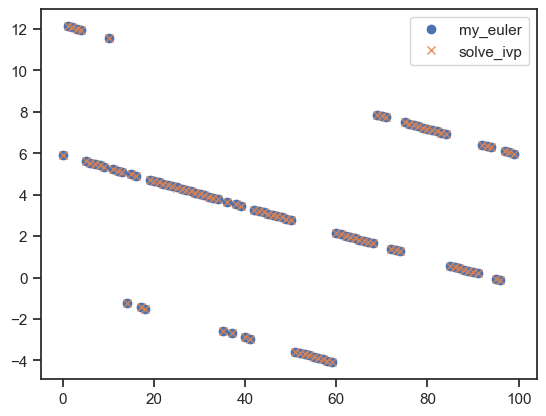

In [649]:
tt = -1

#plt.plot(psi,  "+", label="initial")

plt.plot(thetas[:,tt],  "o", label="my_euler")

plt.plot(solx.y[:,tt], "x", label="solve_ivp", alpha=0.9)

plt.legend()

In [641]:
np.allclose(thetas[:,-1], solx.y[:,-1], atol=1e-2)

True

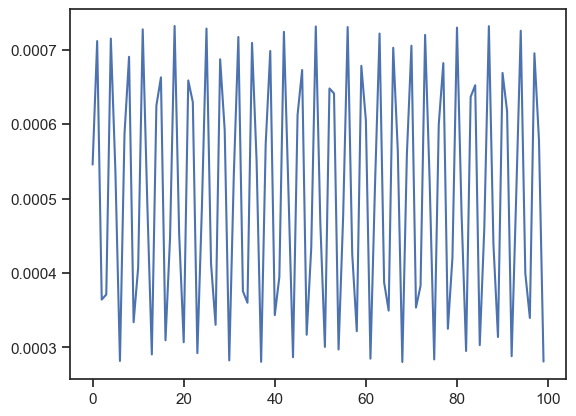

In [642]:
plt.plot(thetas[:,-1] - solx.y[:,-1])

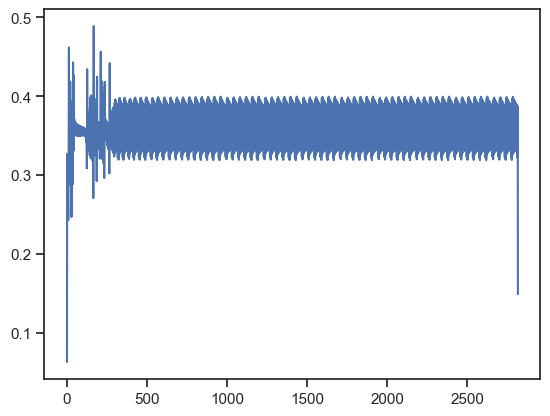

In [643]:
plt.plot(np.diff(solx.t))

In [644]:
solx.y.shape

(100, 2819)

In [636]:
thetas.shape

(100, 1000001)

In [589]:
np.linalg.norm(thetas - solx.y, axis=1)

array([394.61683209, 413.95943911, 433.33608923, 452.74924699,
       472.2007446 , 491.692933  , 511.22794035, 530.80817123,
       550.43599205, 570.11401006, 589.84474902, 609.63136596,
       629.47498859, 649.38133612, 669.35206406, 689.39116363,
       709.50214517, 729.6889705 , 749.95589641, 770.30754036,
       790.74902387, 811.28601366, 831.92483647, 852.67291779,
       873.53848264, 894.5317641 , 915.6654383 , 936.9535432 ,
       958.42337186, 980.08357771, 974.38769675, 952.74088816,
       931.30025392, 910.03549776, 888.9172998 , 867.94732583,
       847.08600772, 826.34913236, 805.71859146, 785.18959043,
       764.75463436, 744.409441  , 724.14712727, 703.96424736,
       683.85697828, 663.82065949, 643.85219363, 623.9480296 ,
       604.10500553, 584.32022307, 564.59054117, 544.91378027,
       525.28659877, 505.70704427, 486.17253188, 466.680803  ,
       447.22960997, 427.81683899, 408.44029937, 389.09845806,
       369.78785052, 350.50869557, 331.25733322, 312.03

In [587]:
solx

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20750
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 9.9998e+02, 9.9999e+02,
       1.0000e+03])
 t_events: None
        y: array([[ 0.71722941,  0.71826084,  0.71926998, ...,  5.91783097,
         5.91783097,  5.91783097],
       [ 4.69287319,  4.69492447,  4.69693378, ..., 12.13818443,
        12.13818443, 12.13818443],
       [ 5.90884926,  5.89870151,  5.88869398, ..., 12.07535255,
        12.07535255, 12.07535255],
       ...,
       [ 4.14522822,  4.14825568,  4.15125075, ...,  6.10632654,
         6.10632654,  6.10632654],
       [ 2.89861088,  2.89287848,  2.88716807, ...,  6.04349467,
         6.04349467,  6.04349467],
       [ 2.05567638,  2.0614548 ,  2.06723314, ...,  5.98066281,
         5.98066281,  5.98066281]])
 y_events: None